Here we'll demonstrate the main features of FutureUnknown  

First we'll load an example time series. For this we'll use data from [FRED](fred.stlouisfed.org), specifically the monthly average price of potato chips in the us. This will be loaded and formatted as a time series in pandas.

In [1]:
import pandas as pd

path = "../data/raw/APU0000718311.csv"
data = pd.read_csv(path)
data["DATE"] = pd.to_datetime(data["DATE"])
data = data.rename(columns={"APU0000718311": "chips_price", "DATE": "date"})
data = data.set_index("date")

data = data.dropna()
data.index.freq = pd.infer_freq(data.index)
data

,chips_price
date,
1980-01-01,1.981
1980-02-01,1.994
1980-03-01,2.003
1980-04-01,2.006
1980-05-01,2.006
...,...
2023-02-01,6.171
2023-03-01,6.526
2023-04-01,6.623


Now we'll use the create_lagged_values function to add extra columns which contain values from previous months. Items are input into the forecasting model as single rows, so lagged columns are necessary if historical values are to be used for forecasting.

In [2]:
from futureunknown.data import create_lagged_values

data = create_lagged_values(df=data, n_lags=6, column="chips_price").dropna()
data

,chips_price,chips_price_lag1,chips_price_lag2,chips_price_lag3,chips_price_lag4,chips_price_lag5,chips_price_lag6
date,,,,,,,
1980-07-01,2.012,2.018,2.006,2.006,2.003,1.994,1.981
1980-08-01,2.046,2.012,2.018,2.006,2.006,2.003,1.994
1980-09-01,2.035,2.046,2.012,2.018,2.006,2.006,2.003
1980-10-01,2.066,2.035,2.046,2.012,2.018,2.006,2.006
1980-11-01,2.138,2.066,2.035,2.046,2.012,2.018,2.006
...,...,...,...,...,...,...,...
2023-02-01,6.171,6.238,6.283,6.253,6.402,6.058,5.941
2023-03-01,6.526,6.171,6.238,6.283,6.253,6.402,6.058
2023-04-01,6.623,6.526,6.171,6.238,6.283,6.253,6.402


Now we'll create an instance of the MultiPointRegressionForecaster class, providing a regressor instance for it to wrap as an argument. Any regression model could be used in theory, but here we'll use a linear regression model to keep things simple.

In [4]:
from futureunknown.regression import MultiPointRegressionForecaster
from sklearn.linear_model import LinearRegression

model = MultiPointRegressionForecaster(LinearRegression(), horizon=12, stride=1)

We fit the regressor by giving it the data and specifying the column to be forecast, then create the forecast by calling the predict() method of the model. The latest values from the training data are stored internally, so no arguments have to be provided when calling predict().

In [7]:
model.fit(X=data, y="chips_price")
forecast = model.predict()
forecast

2023-07-01    6.370919
2023-08-01    6.441783
2023-09-01    6.487674
2023-10-01    6.441763
2023-11-01    6.438440
2023-12-01    6.500345
2024-01-01    6.533772
2024-02-01    6.487616
2024-03-01    6.529156
2024-04-01    6.556113
2024-05-01    6.555454
2024-06-01    6.526621
Name: forecast, dtype: float64

The individual points of the forecast can sometimes be a little "bumpy", so an optional step to fix this is to smooth the forecast with the smooth_forecast_univariate() function, which fits a univariate spline to the forecast, and optionally the historical data (to help the forecast continue smoothly on from the historical values).

In [10]:
from futureunknown.data import smooth_forecast_univariate

smoothed_forecast = smooth_forecast_univariate(
    forecast=forecast, historical=data["chips_price"], include_last_n=1, s=12
)

Finally, we'll plot the smoothed and unsmoothed forecasts, along with the historical values.

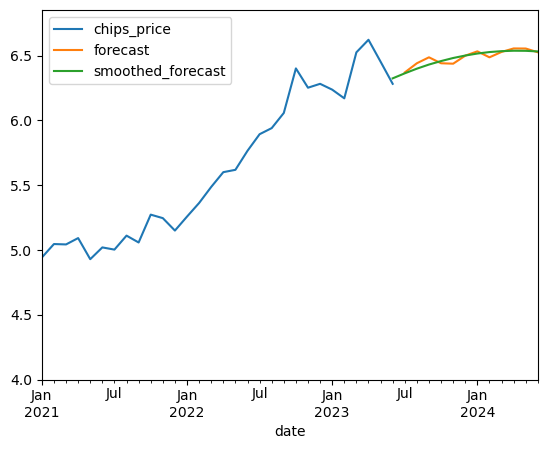

In [16]:
# Plot original series and predictions
ax = data["chips_price"].plot()
ax = forecast.plot(ax=ax)
ax = smoothed_forecast.plot(ax=ax)
_ = ax.legend()
_ = ax.set_xlim(xmin="2021")
_ = ax.set_ylim(ymin=4)